# Introduction

This notebook was created by Rohit Satija (rsatija@berkeley.edu) and is part of a series of classification algorithms used in the steaming-hot project for the May 2021 Erdős Institute Data Science BootCamp

# Data 

In [1]:
#For data manipulation
import pandas as pd
import numpy as np

#For plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('AllData.csv')  # This csv file contains cleaned data of ~10,000 games inlcuding various features
                                   # and mean_player count in the column 'mean'
data = data[data['mean']>1]        # We discard games with mean_player<1 as these represent suspicious games that
                                   # not even the game developer plays
data.shape

(8093, 81)

In [3]:
#Drop columns that are not needed for classification, e.g. Name, App_id, etc
proc_data = data.drop(['App_id','Name','ReleaseDate','Metacritic','SteamSpyOwners', 'SteamSpyOwnersVariance',
                      'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency','SupportEmail', 
                      'SupportURL', 'AboutText','Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice',
                      'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews','RecommendationCount',
                      'SupportedLanguages', 'Website', 'PCMinReqsText', 'PCRecReqsText',
                      'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText','MacRecReqsText',
                      'SteamSpyOwnersNew', 'peak_max', 'peak_mean', 'max'],axis=1)

In [4]:
#This code creates a column called "grade" that one-hot encodes the mean_player count based on popularity
def create_grades(count):
#Return 1 if avg_players>100 and 0 if avg_players<5
        if 100<=count:   
            return 1
        elif count<5:
            return 0
#Return -1 if 5<avg_players<100 in the middle category
        else:
            return -1

proc_data['grade']=proc_data['mean'].apply(create_grades)

#Drop games in the middle category
data_for_classification=proc_data[(proc_data['grade']==0)|(proc_data['grade']==1)]

In [5]:
#Design matrix containing all features
X=data_for_classification.drop(['mean','grade'],axis=1).copy()
X=X.astype(float)

#Target variable: Popularity Grade
y=data_for_classification['grade'].copy()

# Model

In [6]:
#For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

#For performance measurement
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#To prevent ugly warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [7]:
#Create a train-test split of the design matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y,                
                                                    test_size=0.25,    #75-25 split
                                                    random_state = 42, #Random seed for reproducibility
                                                    shuffle=True,      #Shuffle the data before split
                                                    stratify=y)        #Stratify on the target variable to prevent
                                                                       #class imbalance

In [8]:
#The following code runs a 5-fold stratified cross-validation to optimize the hyperparameter C in case of 'l2' penalty
#in the LogisticRegression routine

#Create a kfold object
kfold = StratifiedKFold(5,shuffle = True,random_state = 42)

#Define the range of regularization parameter to search for
cvalues = np.logspace(-5,1,100)

#Create arrays for accuracy_score, precision_score, recall_score, and f1_score
accs = np.zeros((5,len(cvalues)))
prec = np.zeros((5,len(cvalues)))
recs = np.zeros((5,len(cvalues)))
f1s = np.zeros((5,len(cvalues)))

#This is to keep track of the train test split
i = 0

for train_index, test_index in kfold.split(X_train,y_train):
    # Get the cv train test split
    X_train_train, X_train_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]
    for j in range(len(cvalues)):
        #Create a model object
        log_reg_clone = clone(LogisticRegression(class_weight='balanced',penalty='l2',C=cvalues[j]))
        
        #Fit the model
        log_reg_clone.fit(X_train_train,y_train_train)
        
        #Predict
        y_pred = log_reg_clone.predict(X_train_test)
        
        #Measure accuracy, precision, recall, f1
        accs[i,j] = accuracy_score(y_train_test,y_pred)
        prec[i,j] = precision_score(y_train_test,y_pred)
        recs[i,j] = recall_score(y_train_test,y_pred)
        f1s[i,j] = f1_score(y_train_test,y_pred)
        
    i=i+1

# Result

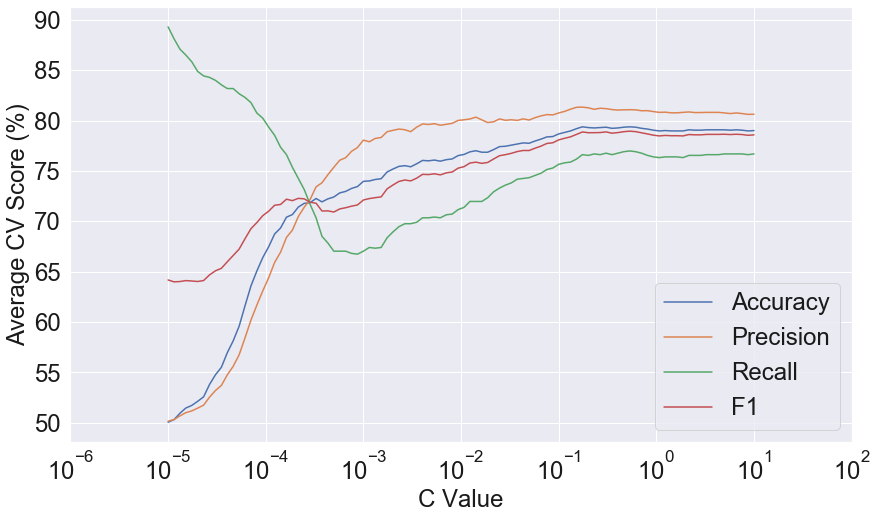

In [9]:
#Plot the result
plt.figure(figsize=(14,8))
fontsize=24
fontcolor='k'

plt.plot(cvalues, 100*np.mean(accs, axis=0),label='Accuracy')
plt.plot(cvalues, 100*np.mean(prec, axis=0),label='Precision')
plt.plot(cvalues, 100*np.mean(recs, axis=0),label='Recall')
plt.plot(cvalues, 100*np.mean(f1s, axis=0),label='F1')

plt.xlabel("C Value", fontsize=fontsize,color=fontcolor)
plt.ylabel("Average CV Score (%)", fontsize=fontsize,color=fontcolor)

plt.setp(plt.legend(fontsize=fontsize).get_texts(), color=fontcolor)
plt.xticks(fontsize=fontsize,color=fontcolor)
plt.xscale('log')
plt.xlim(cvalues[0]*0.1,cvalues[-1]*10)
plt.yticks(fontsize=fontsize,color=fontcolor)
plt.show()

In [10]:
print("The c-value with highest mean CV accuracy was",
         cvalues[np.argmax(np.mean(accs,axis=0))])
print("The c-value with highest mean CV precision was",
         cvalues[np.argmax(np.mean(prec,axis=0))])
print("The c-value with highest mean CV recall was",
         cvalues[np.argmax(np.mean(recs,axis=0))])
print("The c-value with highest mean CV F1 score was",
         cvalues[np.argmax(np.mean(f1s,axis=0))])

The c-value with highest mean CV accuracy was 0.5336699231206312
The c-value with highest mean CV precision was 0.1747528400007683
The c-value with highest mean CV recall was 1e-05
The c-value with highest mean CV F1 score was 0.5336699231206312


It is clear that C = 1e-5 gives best recall but poor accuracy, precision, and f-1 scores. Since our model must generally perform well in all metrics, we instead focus on C = 0.53. 

In [11]:
#Let us now train our validated model with C=0.53 on the full training set and calculate performance on 
#test set
log_reg = LogisticRegression(class_weight='balanced',C=0.534,penalty='l2')

log_reg.fit(X_train,y_train)

y_pred = log_reg.predict(X_test)

print('Test set Accuracy: ',np.round(100*accuracy_score(y_test,y_pred),2))
print('Test set Precision: ',np.round(100*precision_score(y_test,y_pred),2))
print('Test set Recall: ',np.round(100*recall_score(y_test,y_pred),2))
print('Test set F1-score: ',np.round(100*f1_score(y_test,y_pred),2))

Test set Accuracy:  79.11
Test set Precision:  80.05
Test set Recall:  77.92
Test set F1-score:  78.97


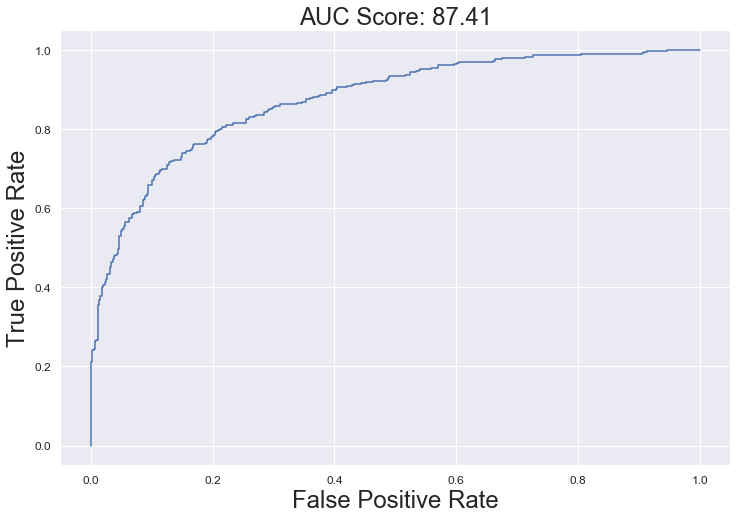

In [12]:
#Plot the ROC curve and calculate the final AUC score on the test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = log_reg.predict_proba(X_test)

fpr,tpr,cutoffs = roc_curve(y_test,probs[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr,tpr)

plt.title("AUC Score: "+str(np.round(100*roc_auc_score(y_test,probs[:,1]),2)),fontsize=fontsize)
plt.xlabel("False Positive Rate",fontsize=fontsize)
plt.ylabel("True Positive Rate",fontsize=fontsize)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

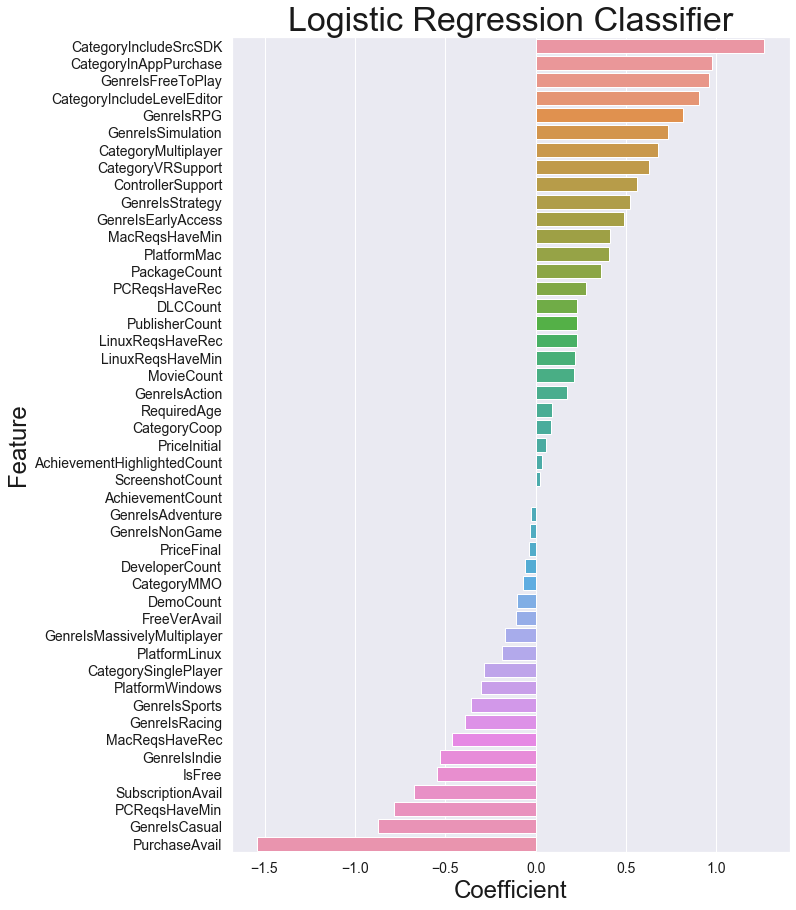

In [14]:
#In this case, we can also detect coefficients and guage feature importance
names = []
scores = []
for name, score in zip(X_test.columns,log_reg.coef_[0]):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'coefficients':scores})
score_df.sort_values('coefficients',ascending=False)

f,ax = plt.subplots(figsize=(10,15))

plt.title('Logistic Regression Classifier',fontsize=fontsize+10,color=fontcolor)
sns.barplot(x="coefficients", y="feature", data=score_df.sort_values('coefficients',ascending=False))

plt.xlabel("Coefficient",fontsize=fontsize,color=fontcolor)
plt.ylabel("Feature",fontsize=fontsize,color=fontcolor)

plt.xticks(fontsize=fontsize-10,color=fontcolor)
plt.yticks(fontsize=fontsize-10,color=fontcolor)
plt.show()

__That's all folks!__